In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
class GanglionCellResponse(ec2b.TemporalModel):
    def __init__(self, tsample):
        super(GanglionCellResponse, self).__init__(tsample)
        
    def stationary_nonlinearity(self, resp):
        return resp
    
    def slow_response(self, resp):
        return resp

In [3]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [4]:
# Monophasic pulse
def get_monophasic_pulse(pulse_dur, stim_dur, freq, amp, tsample, ptype='cathodic', delay_dur=0.01):
    assert pulse_dur > 0
    assert stim_dur > 0
    assert delay_dur > 0
    
    stim_size = int(round(stim_dur / tsample))
    if amp == 0 or freq == 0:
        return TimeSeries(tsample, np.zeros(stim_size))

    pulse_size = int(round(pulse_dur / tsample))
    envelope_size = int(round(1.0 / float(freq) / tsample))
    delay_size = int(round(delay_dur / tsample))
    assert pulse_size <= envelope_size
    assert pulse_size <= stim_size
    
    pulse = np.ones(pulse_size)
    if ptype == 'cathodic':
        pulse *= -amp
    elif ptype == 'anodic':
        pulse *= amp
    else:
        raise ValueError("Unknown `ptype` '" + ptype + "'")
    gap = np.zeros(envelope_size - pulse_size)
    
    pulse_train = np.array([])
    for j in range(int(np.ceil(stim_dur * freq))):
        pulse_train = np.concatenate((pulse_train, pulse, gap), axis=0)
        
    delay = np.zeros(delay_size)
    pulse_train = np.concatenate((delay, pulse_train), axis=0)
    pulse_train = pulse_train[:stim_size]
    
    return TimeSeries(tsample, pulse_train)

(-5000, 20000)

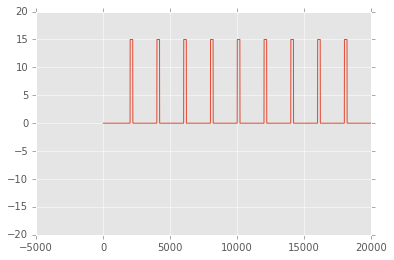

In [5]:
pt = get_monophasic_pulse(1.0 / 1000, 100.0 / 1000, 100, 15, 0.005 / 1000, 'anodic')
plt.plot(pt.data)
plt.ylim(-20, 20)
plt.xlim(-5000, 20000)

In [6]:
# Stimulating electrodes: disc-shaped, 125um and 500um diameter, electrode-retina distance unknown
e125 = e2cm.ElectrodeArray('epiretinal', 125.0 / 2, -500, -500, 0, 'E125')
e500 = e2cm.ElectrodeArray('epiretinal', 500.0 / 2, -500, -500, 0, 'E500')

In [7]:
# Create a retina
r_sampling = 100       # spatial sampling of retina
axon_lambda = 2        # constant that determines fall-off with axonal distance
rot = 0 * np.pi / 180  # retina rotation angle
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=rot,
                     xlo=-500, xhi=-500, ylo=-500, yhi=-500)
#                      xlo=-1500, xhi=500, ylo=-1500, yhi=500)

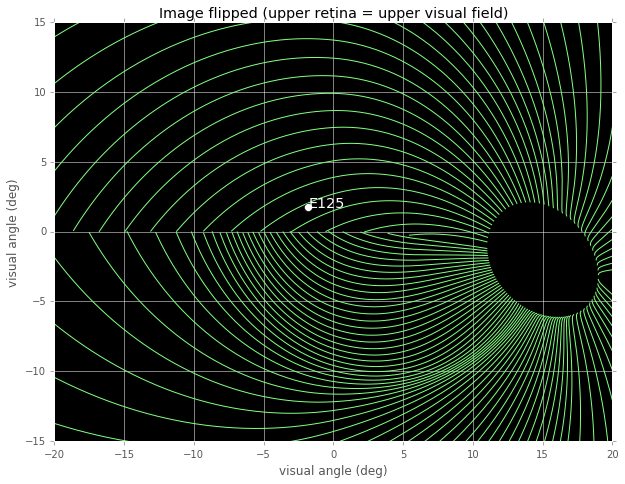

In [8]:
from matplotlib import patches

# Plot axon bundles (plot every 5th for the sake of visualization)
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.set_axis_bgcolor('black')
ax.plot(retina.jan_x[:, ::5], -retina.jan_y[:, ::5], c=(0.5, 1, 0.5))

# Draw in the the retinal patch we're simulating.
# This defines the size of our "percept" image below.
ax.add_patch(patches.Rectangle((e2cm.micron2deg(retina.gridx.min()), 
                                -e2cm.micron2deg(retina.gridy.max())),
                               e2cm.micron2deg(retina.gridx.max() - retina.gridx.min()),
                               e2cm.micron2deg(retina.gridy.max() - retina.gridy.min()),
                               alpha=0.7))

# Plot all electrodes and their label
for e in e125.electrodes:
    ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5), e.name,
            color='white', size='x-large')
    ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
            markersize=np.sqrt(e.radius))

ax.set_aspect('equal')
ax.set_xlim(-20, 20)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-15, 15)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')

In [9]:
# Data extracted from Fig. 5 in Jensen et al. (2005)
# Axonal stimulation only

# 125 um, 0.1 ms
jensen_125_h01 = np.array([0, 3.49149, 49.49211, 4.93797, 99.58362, 9.51688, 149.75063, 12.19050, 
                           198.90872, 36.68733, 299.46237, 183.41754, 398.49234, 349.14896]).reshape((-1, 2))

# 500 um, 0.1 ms
jensen_500_h01 = np.array([0, 14.34171, 48.75000, 24.59424, 99.58333, 49.36522, 148.33333, 100.31863,
                           198.75000, 187.24588, 298.75000, 351.63856, 397.91667, 459.12382]).reshape((-1, 2))

# 125 um, 1 ms
jensen_125_h1 = np.array([0, 0.69783, 49.57602, 1.07461, 99.40599, 2.77146, 149.33927, 4.01945, 
                          199.13481, 12.55909, 299.34143, 39.71534, 398.80122, 80.58422]).reshape((-1, 2))

# 500 um, 1 ms
jensen_500_h1 = np.array([0, 2.79305, 49.56506, 3.45266, 98.39239, 6.93181, 147.97507, 21.78898, 
                          198.56416, 26.93464, 298.41882, 59.93593, 398.31972, 103.40334]).reshape((-1, 2))

# 125 um, 10 ms
jensen_125_h10 = np.array([0, 0.69251, 48.94730, 1.00000, 98.98513, 2.56788, 149.53263, 3.99084, 
                           198.69358, 12.77565, 298.90724, 39.42255, 399.21882, 70.96821]).reshape((-1, 2))

# 500 um, 10 ms
jensen_500_h10 = np.array([0, 2.21828, 49.01961, 2.37154, 98.47063, 5.18242, 147.91303, 11.88743, 
                           197.81488, 20.63321, 296.86145, 43.74543, 396.36101, 72.77994]).reshape((-1, 2))

In [10]:
def run_fig5(implant, retina, pulse_dur, amp_th):
    tsample = 0.005 / 1000
    stim_dur = 0.5
    stim_freq = 2
    use_ecs = True
    ptype = 'cathodic'
    
    # Don't execute the full model cascade: We're interested in RGC-like responses
    tm = GanglionCellResponse(tsample=tsample)
    
    # Electrode-retina distances used in experiments (um)
    heights = np.array([0, 50, 100, 150, 200, 300, 400])
    
    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    stim = get_monophasic_pulse(pulse_dur, stim_dur, stim_freq, amp_th, tsample, ptype)
    implant[0].height = heights[0]
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=use_ecs, engine='joblib', tol=0.2)
#     mov.data = mov.data[2:-3, 2:-3, :]
    act_match = 5.0
#     act_match = mov.data.max()
    print('Threshold: amp_in=%f act_out=%f' % (amp_th, act_match))
    
    amp_in = [act_match / 10.0, act_match * 10.0]
    print('Using current: [%f, %f]' % (amp_in[0], amp_in[1]))

    amp_match = []
    for ht in heights:
        print('Processing height %f' % ht)
        implant[0].height = ht
        act_out = []
        for amp in amp_in:
            stim = get_monophasic_pulse(pulse_dur, stim_dur, stim_freq, amp, tsample, ptype)
            mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=use_ecs, engine='joblib', tol=0.2)
#             mov.data = mov.data[2:-3, 2:-3, :]
            act_out.append(mov.data.max())
        amp_match.append(fit_amps(amp_in, act_out, act_match))
        
    return heights, amp_match

In [11]:
# Generate data for 125 um, 0.1 ms pulse dur plot
heights_125_h01, model_125_h01 = run_fig5(e125, retina, 0.1 / 1000, jensen_125_h01[0, 1])

tol=0.200, 1/2 pixels selected
Threshold: amp_in=3.491490 act_out=5.000000
Using current: [0.500000, 50.000000]
Processing height 0.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 50.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 100.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 150.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 200.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 300.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 400.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected


In [12]:
# Generate data for 500 um, 0.1 ms pulse dur plot
heights_500_h01, model_500_h01 = run_fig5(e500, retina, 0.1 / 1000, jensen_500_h01[0, 1])

tol=0.200, 1/2 pixels selected
Threshold: amp_in=14.341710 act_out=5.000000
Using current: [0.500000, 50.000000]
Processing height 0.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 50.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 100.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 150.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 200.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 300.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 400.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected


In [13]:
# Generate data for 125 um, 1 ms pulse dur plot
heights_125_h1, model_125_h1 = run_fig5(e125, retina, 1.0 / 1000, jensen_500_h1[0, 1])

tol=0.200, 1/2 pixels selected
Threshold: amp_in=2.793050 act_out=5.000000
Using current: [0.500000, 50.000000]
Processing height 0.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 50.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 100.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 150.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 200.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 300.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 400.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected


In [14]:
# Generate data for 500 um, 1 ms pulse dur plot
heights_500_h1, model_500_h1 = run_fig5(e500, retina, 1.0 / 1000, jensen_500_h1[0, 1])

tol=0.200, 1/2 pixels selected
Threshold: amp_in=2.793050 act_out=5.000000
Using current: [0.500000, 50.000000]
Processing height 0.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 50.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 100.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 150.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 200.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 300.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 400.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected


In [15]:
# Generate data for 125 um, 10 ms pulse dur plot
heights_125_h10, model_125_h10 = run_fig5(e125, retina, 10.0 / 1000, jensen_500_h10[0, 1])

tol=0.200, 1/2 pixels selected
Threshold: amp_in=2.218280 act_out=5.000000
Using current: [0.500000, 50.000000]
Processing height 0.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 50.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 100.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 150.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 200.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 300.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 400.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected


In [16]:
# Generate data for 500 um, 10 ms pulse dur plot
heights_500_h10, model_500_h10 = run_fig5(e500, retina, 10.0 / 1000, jensen_500_h10[0, 1])

tol=0.200, 1/2 pixels selected
Threshold: amp_in=2.218280 act_out=5.000000
Using current: [0.500000, 50.000000]
Processing height 0.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 50.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 100.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 150.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 200.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 300.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected
Processing height 400.000000
tol=0.200, 1/2 pixels selected
tol=0.200, 1/2 pixels selected


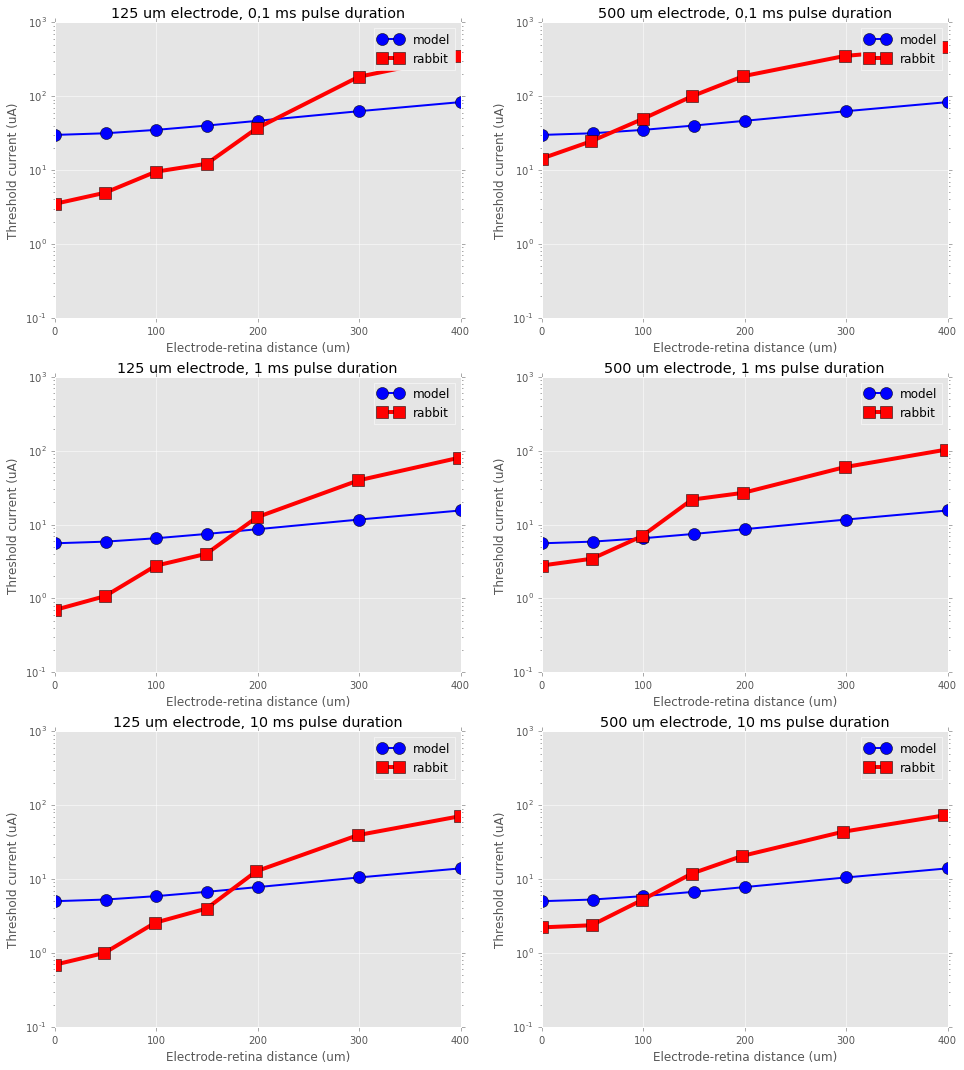

In [17]:
plt.figure(figsize=(16, 18))

plt.subplot(321)
plt.semilogy(heights_125_h01, model_125_h01, 'o-b', linewidth=2, markersize=12, label='model')
plt.semilogy(jensen_125_h01[:, 0], jensen_125_h01[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0, 100, 200, 300, 400]))
plt.yticks([0.1, 1, 10, 100, 1000])
plt.xlabel('Electrode-retina distance (um)')
plt.ylabel('Threshold current (uA)')
plt.title('125 um electrode, 0.1 ms pulse duration')
plt.legend()

plt.subplot(322)
plt.semilogy(heights_500_h01, model_500_h01, 'o-b', linewidth=2, markersize=12, label='model')
plt.semilogy(jensen_500_h01[:, 0], jensen_500_h01[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0, 100, 200, 300, 400]))
plt.yticks([0.1, 1, 10, 100, 1000])
plt.xlabel('Electrode-retina distance (um)')
plt.ylabel('Threshold current (uA)')
plt.title('500 um electrode, 0.1 ms pulse duration')
plt.legend()

plt.subplot(323)
plt.semilogy(heights_125_h1, model_125_h1, 'o-b', linewidth=2, markersize=12, label='model')
plt.semilogy(jensen_125_h1[:, 0], jensen_125_h1[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0, 100, 200, 300, 400]))
plt.yticks([0.1, 1, 10, 100, 1000])
plt.xlabel('Electrode-retina distance (um)')
plt.ylabel('Threshold current (uA)')
plt.title('125 um electrode, 1 ms pulse duration')
plt.legend()

plt.subplot(324)
plt.semilogy(heights_500_h1, model_500_h1, 'o-b', linewidth=2, markersize=12, label='model')
plt.semilogy(jensen_500_h1[:, 0], jensen_500_h1[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0, 100, 200, 300, 400]))
plt.yticks([0.1, 1, 10, 100, 1000])
plt.xlabel('Electrode-retina distance (um)')
plt.ylabel('Threshold current (uA)')
plt.title('500 um electrode, 1 ms pulse duration')
plt.legend()

plt.subplot(325)
plt.semilogy(heights_125_h10, model_125_h10, 'o-b', linewidth=2, markersize=12, label='model')
plt.semilogy(jensen_125_h10[:, 0], jensen_125_h10[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0, 100, 200, 300, 400]))
plt.yticks([0.1, 1, 10, 100, 1000])
plt.xlabel('Electrode-retina distance (um)')
plt.ylabel('Threshold current (uA)')
plt.title('125 um electrode, 10 ms pulse duration')
plt.legend()

plt.subplot(326)
plt.semilogy(heights_500_h10, model_500_h10, 'o-b', linewidth=2, markersize=12, label='model')
plt.semilogy(jensen_500_h10[:, 0], jensen_500_h10[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0, 100, 200, 300, 400]))
plt.yticks([0.1, 1, 10, 100, 1000])
plt.xlabel('Electrode-retina distance (um)')
plt.ylabel('Threshold current (uA)')
plt.title('500 um electrode, 10 ms pulse duration')
plt.legend()

plt.savefig('jensen2005_fig5.eps')
plt.savefig('jensen2005_fig5.png')